In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [6]:
file_path = '/workspaces/STdata_prediction/src/ST-graph/input/graph_sensor_locations_bay.csv'

In [7]:
data = pd.read_csv(file_path)
indexes = data['index']
latitudes = data['latitude']
longitudes = data['longitude']

In [8]:
# データを用いた処理の例
# 例えば、経度と緯度を使って距離行列を計算する場合
def euclidean_distance(lat1, lon1, lat2, lon2):
    return ((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2) ** 0.5

num_sensors = len(indexes)
distance_matrix = np.zeros((num_sensors, num_sensors))

for i in range(num_sensors):
    for j in range(num_sensors):
        if i != j:
            distance_matrix[i, j] = euclidean_distance(latitudes[i], longitudes[i], latitudes[j], longitudes[j])

print(distance_matrix)

[[0.         0.11930777 0.00734992 ... 0.0413912  0.04127735 0.05056487]
 [0.11930777 0.         0.11271034 ... 0.09121159 0.08519555 0.06952101]
 [0.00734992 0.11271034 0.         ... 0.03883544 0.03738332 0.04458247]
 ...
 [0.0413912  0.09121159 0.03883544 ... 0.         0.0080898  0.02667732]
 [0.04127735 0.08519555 0.03738332 ... 0.0080898  0.         0.01875761]
 [0.05056487 0.06952101 0.04458247 ... 0.02667732 0.01875761 0.        ]]


In [9]:
# Find the index of the smallest distance (excluding the diagonal)
min_distance = np.inf
min_index = (None, None)

for i in range(num_sensors):
    for j in range(i + 1, num_sensors):  # Start from i+1 to avoid the diagonal
        if distance_matrix[i, j] < min_distance:
            min_distance = distance_matrix[i, j]
            min_index = (i, j)

print(f"The smallest distance is between indexes {min_index[0]} and {min_index[1]} with a distance of {min_distance}")

The smallest distance is between indexes 241 and 245 with a distance of 3.046309242304876e-05


In [11]:
# ファイルのパス
file_path = '/workspaces/STdata_prediction/src/ST-graph/input/pems-bay.h5'

# .h5ファイルの読み取り専用モードでの読み込み
with h5py.File(file_path, 'r') as f:
    # データセットのリストを取得
    dataset_list = list(f.keys())
    print("Available datasets:", dataset_list)

    # dfグループ内のデータセットを取得
    df_group = f['speed']
    print(f"\nGroups and datasets in 'df': {list(df_group.keys())}\n")

    # 各データセットの内容を表示
    for key in df_group.keys():
        data = df_group[key][:]
        print(f"Dataset: {key}")
        print(data.shape)
        print("\n")

Available datasets: ['speed']

Groups and datasets in 'df': ['axis0', 'axis1', 'block0_items', 'block0_values']

Dataset: axis0
(325,)


Dataset: axis1
(52116,)


Dataset: block0_items
(325,)


Dataset: block0_values
(52116, 325)




In [13]:
with h5py.File(file_path, 'r') as f:
    # dfグループ内のデータセットを取得
    df_group = f['speed']

    # 各データセットを取得
    axis0 = df_group['axis0'][:]
    axis1 = df_group['axis1'][:]
    block0_items = df_group['block0_items'][:]
    block0_values = df_group['block0_values'][:]

    # DataFrameの作成
    df = pd.DataFrame(block0_values, index=axis1, columns=block0_items)

# DataFrameの表示
print(df.head())

                     400001  400017  400030  400040  400045  400052  400057  \
1483228800000000000    71.4    67.8    70.5    67.4    68.8    66.6    66.8   
1483229100000000000    71.6    67.5    70.6    67.5    68.7    66.6    66.8   
1483229400000000000    71.6    67.6    70.2    67.4    68.7    66.1    66.8   
1483229700000000000    71.1    67.5    70.3    68.0    68.5    66.7    66.6   
1483230000000000000    71.7    67.8    70.2    68.1    68.4    66.9    66.1   

                     400059  400065  400069  ...  409525  409526  409528  \
1483228800000000000    68.0    66.8    69.0  ...    68.8    67.9    68.8   
1483229100000000000    67.8    66.5    68.2  ...    68.4    67.3    68.4   
1483229400000000000    67.8    66.2    67.8  ...    68.4    67.4    68.4   
1483229700000000000    67.7    65.9    67.8  ...    68.5    67.5    68.5   
1483230000000000000    67.7    66.1    67.8  ...    68.5    67.7    68.5   

                     409529  413026  413845  413877  413878  414284 

In [14]:
def plot_graph(speed_values, start_index, end_index):
    plt.figure(figsize=(12, 8))
    indices = np.arange(speed_values.shape[0])
    colors = plt.cm.get_cmap('tab10', end_index - start_index + 1)  # カラーマップを使用

    for i, idx in enumerate(range(start_index, end_index + 1)):
        if idx < speed_values.shape[1]:  # Ensure the index is within bounds
            values_index = speed_values.iloc[:, idx].values
            plt.plot(indices, values_index, linestyle='-', label=f'Values at Index {idx}', 
                     color=colors(i), alpha=0.5)

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Values from Index {start_index} to {end_index}')
    #plt.legend()
    plt.grid(True)
    plt.ylim(0, 100)
    plt.show()

/tmp/ipykernel_6421/1594252672.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', end_index - start_index + 1)  # カラーマップを使用


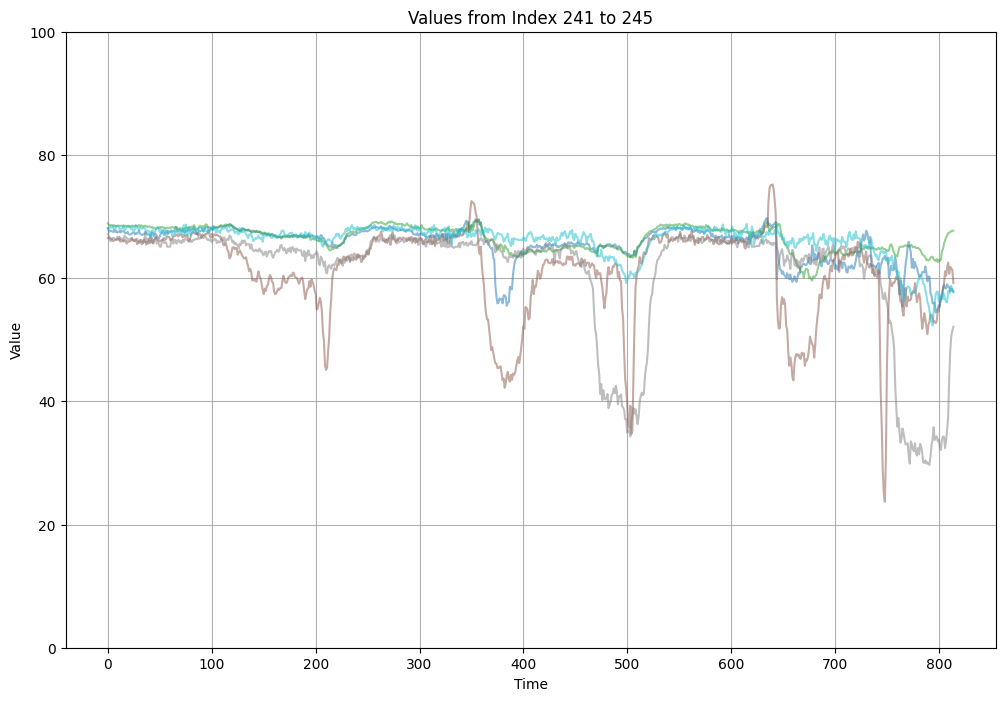

In [16]:
plot_graph(np.array_split(df, 64)[0], 241, 245)

In [17]:
from scipy.cluster.hierarchy import linkage, fcluster

# クラスタリングの実行
# 'ward'法はクラスタ間の分散が最小となるようにクラスタを結合する方法です
Z = linkage(distance_matrix, method='ward')

# クラスタ数を決定 (例: 2クラスタ)
num_clusters = 25
clusters = fcluster(Z, num_clusters, criterion='maxclust')

# クラスタリング結果の表示
for i in range(num_clusters):
    cluster_indices = np.where(clusters == i + 1)[0]
    print(f"Cluster {i + 1}: {cluster_indices}")


Cluster 1: [ 32  92 172 173 194 195 239 252 286 290 293 294 295 296 298 303 304 306
 307 308]
Cluster 2: [ 22  27 119 156 157 178 179 180 183 291 301]
Cluster 3: [ 61  75 189 224 225 247 249 287 288 289 292 297 299 300 302 305 309]
Cluster 4: [ 51  76  80 103 146 188]
Cluster 5: [ 25  45  84  93 107 109 122 133 187 218 219 220 221 222 223 248 250 251]
Cluster 6: [ 13  23  38  49 120 138 153 154 199 209 210 319 320]
Cluster 7: [ 14  17  30  64  79 135]
Cluster 8: [  9  31  40  54  55 121 186 246]
Cluster 9: [  7  21  52  96  98 101 104 106]
Cluster 10: [  1  10  33  39  46  62  67  69  86  94 100 108 112 115 123 127 228]
Cluster 11: [ 11  29  70  71  85  91 113 114 143 144]
Cluster 12: [48 58 60 77]
Cluster 13: [ 15  35  81 129 238 240]
Cluster 14: [  6  73  99 102 128 147 149 164 310 311 312 313]
Cluster 15: [ 16  34  50 141 142 145 235 236 237 257 324]
Cluster 16: [  0   2   4  18  19  56  68 126 132 134 151 158 160 216 217 253 254]
Cluster 17: [ 20  41  53  72  97 191 192 193 197 198

/tmp/ipykernel_6421/1809888641.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


In [18]:
def plot_graphs_by_cluster(speed_values, clusters, num_clusters):
    indices = np.arange(speed_values.shape[0])
    colors = plt.cm.get_cmap('tab10', speed_values.shape[1])  # カラーマップを使用

    for cluster in range(1, num_clusters + 1):
        plt.figure(figsize=(12, 8))
        cluster_indices = np.where(clusters == cluster)[0]
        
        for idx in cluster_indices:
            values_index = speed_values.iloc[:, idx].values
            plt.plot(indices, values_index, linestyle='-', 
                     label=f'Index {idx}', 
                     color=colors(idx), alpha=0.5)

        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Cluster {cluster} Values')
        plt.legend()
        plt.grid(True)
        plt.ylim(0, 100)
        plt.show()

/workspaces/STdata_prediction/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/tmp/ipykernel_6421/889443620.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', speed_values.shape[1])  # カラーマップを使用


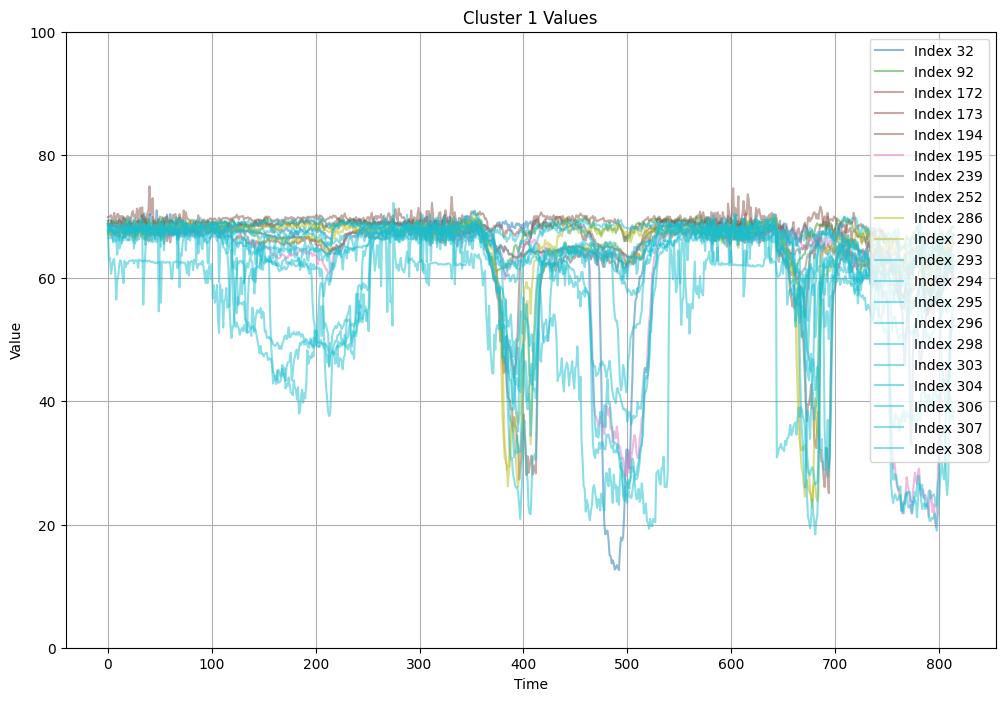

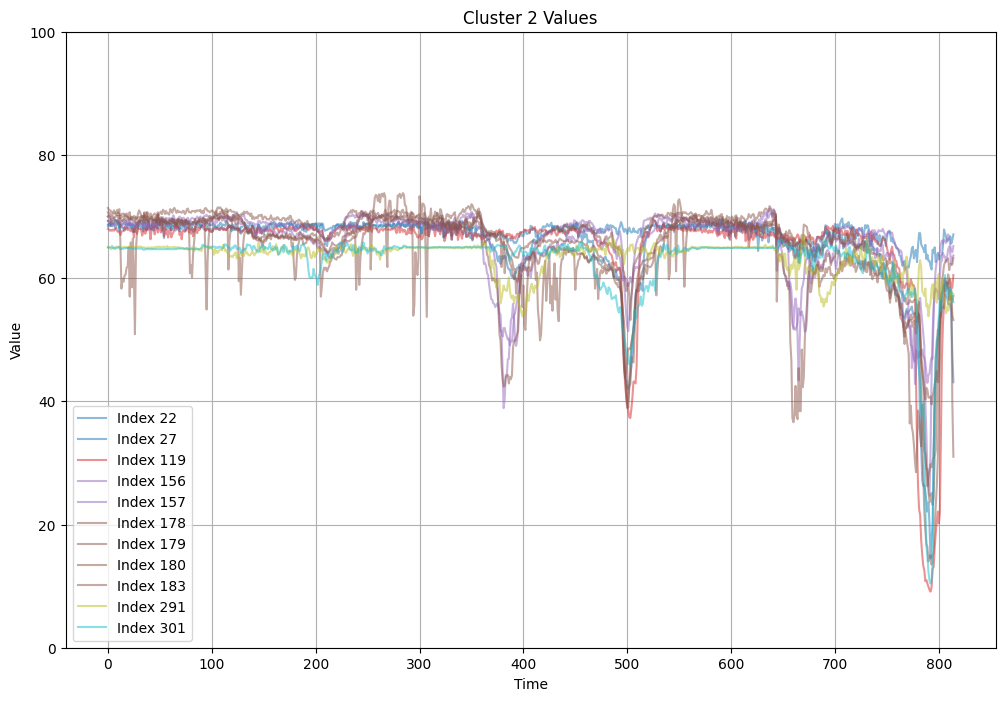

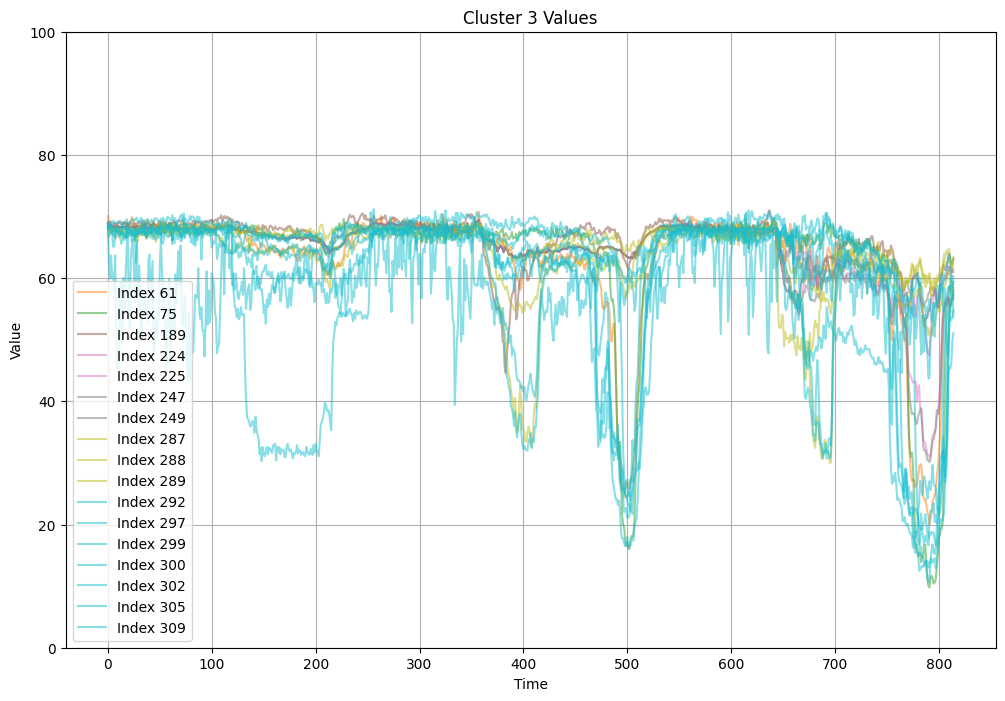

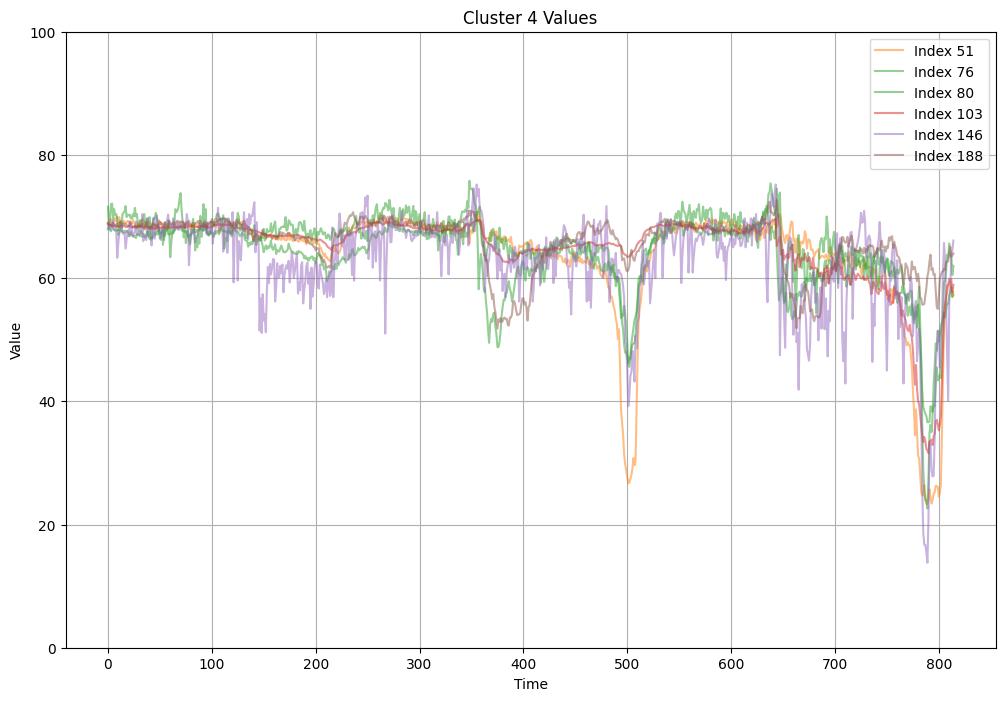

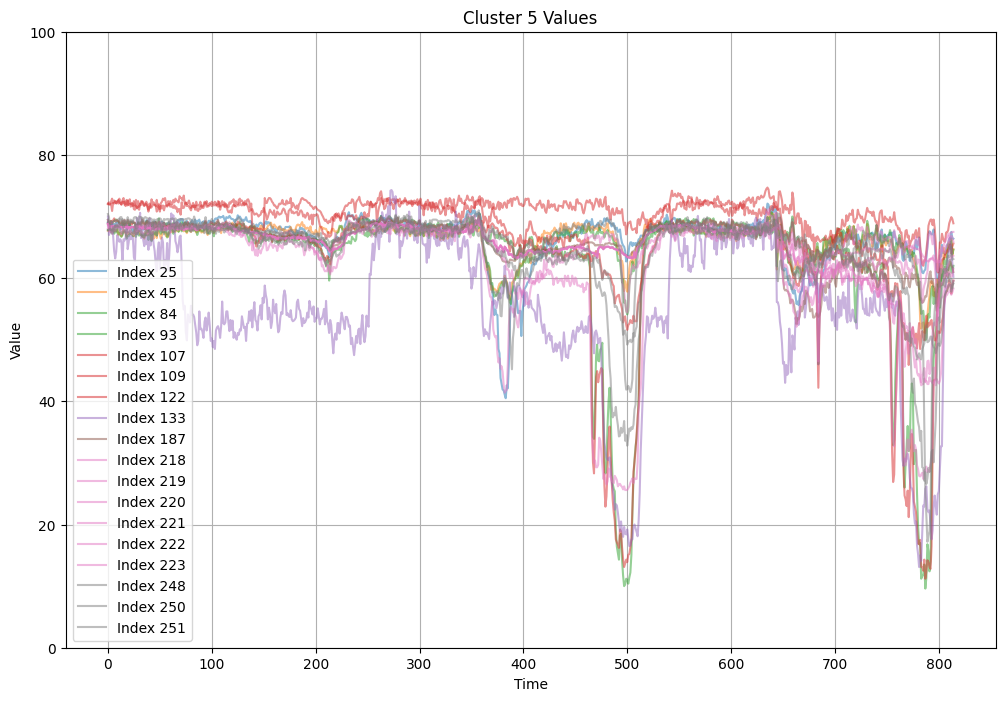

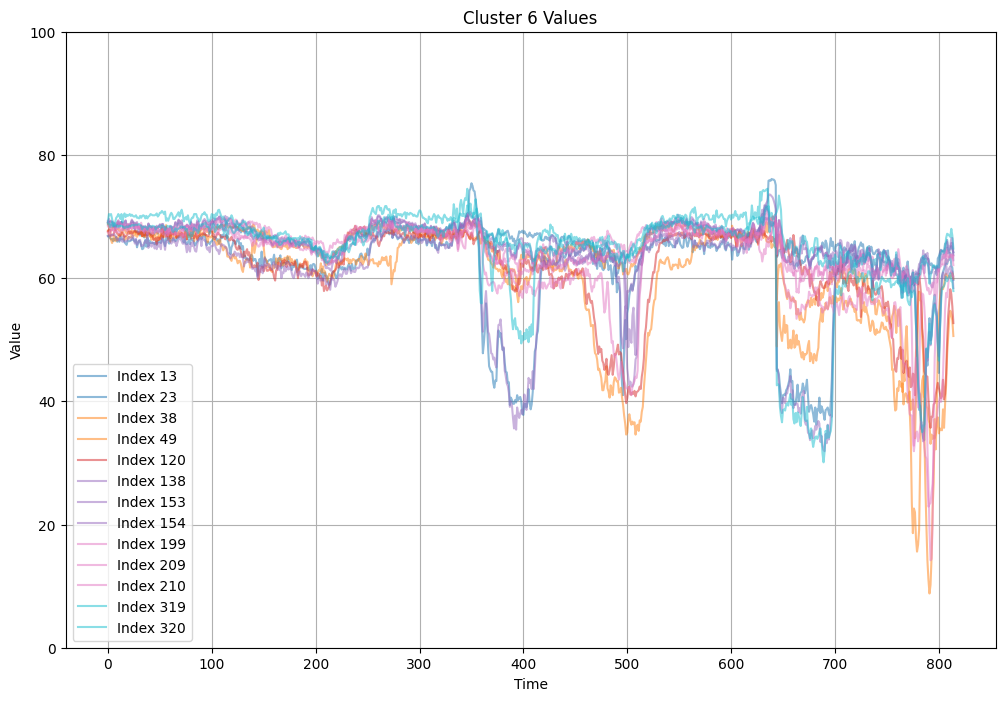

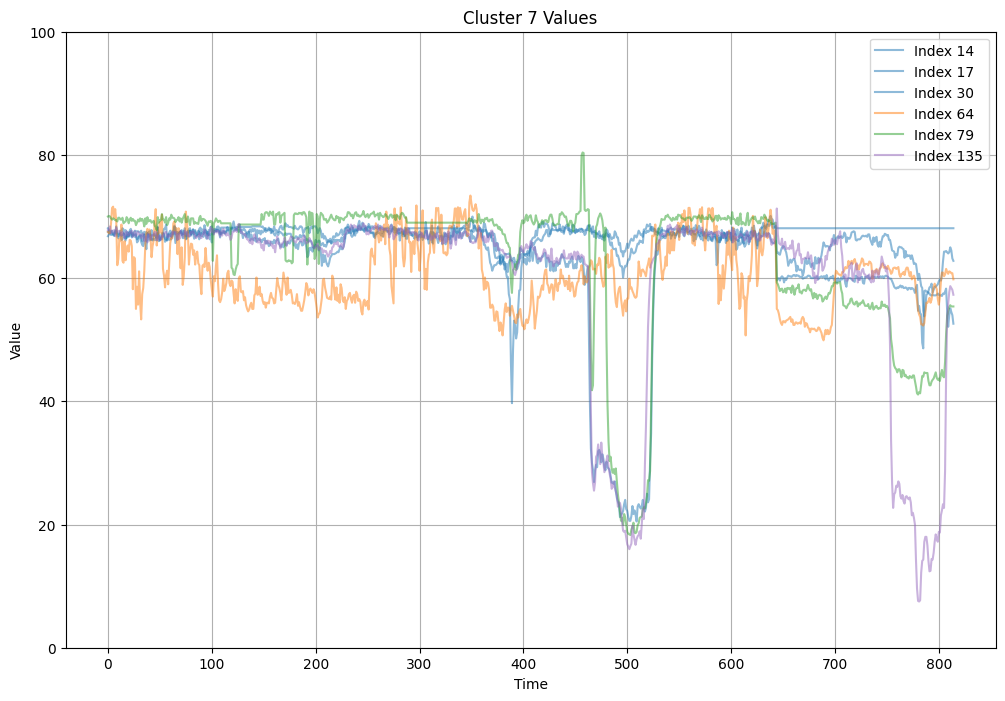

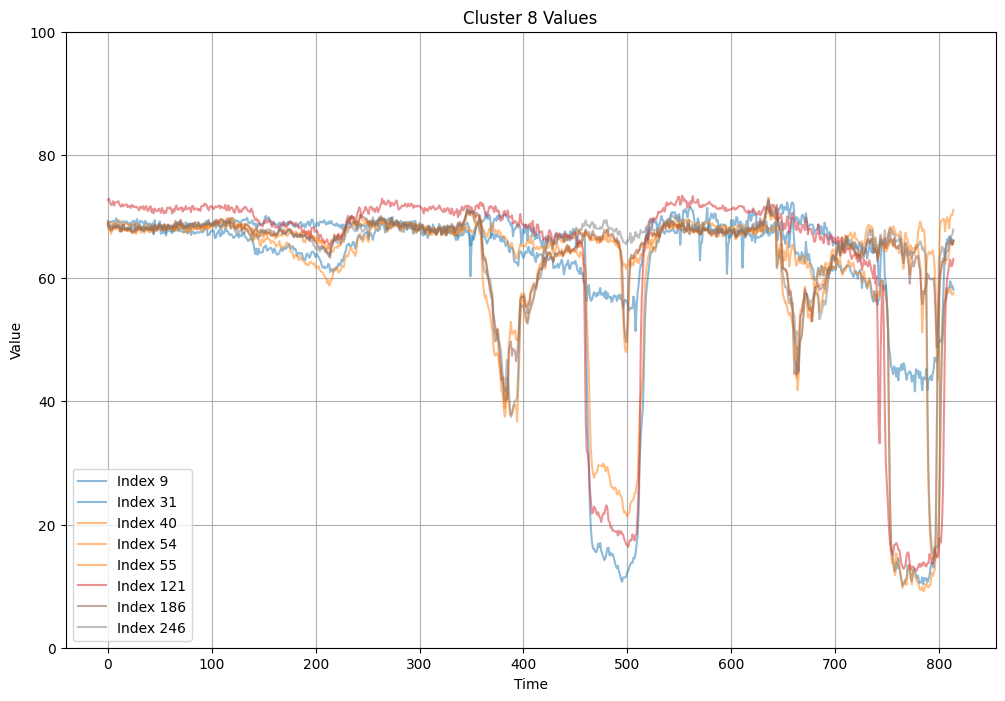

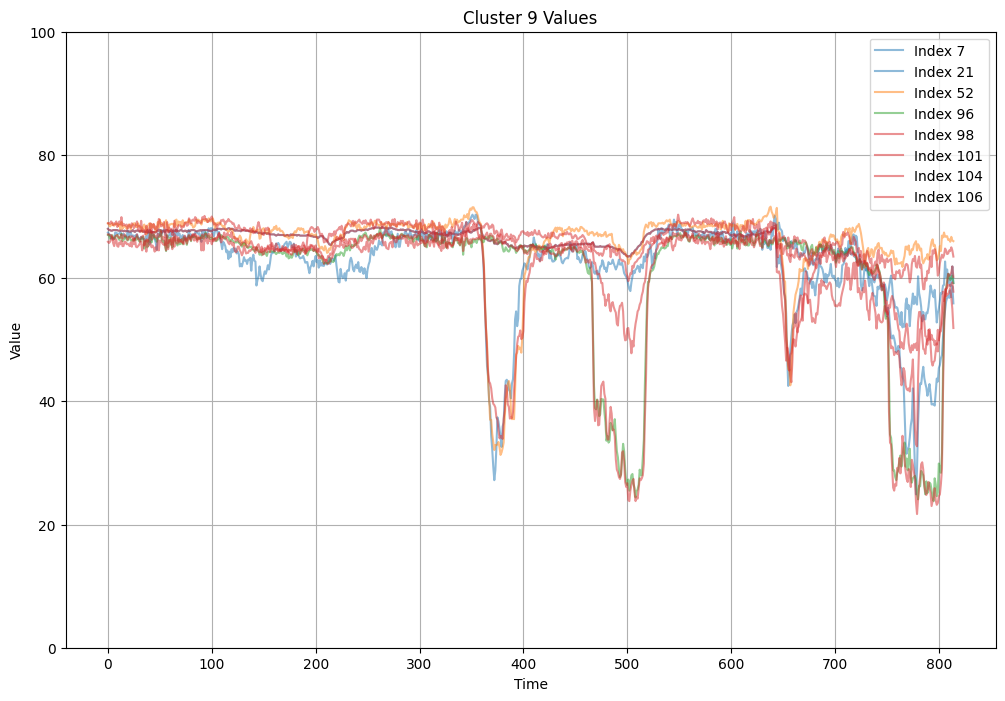

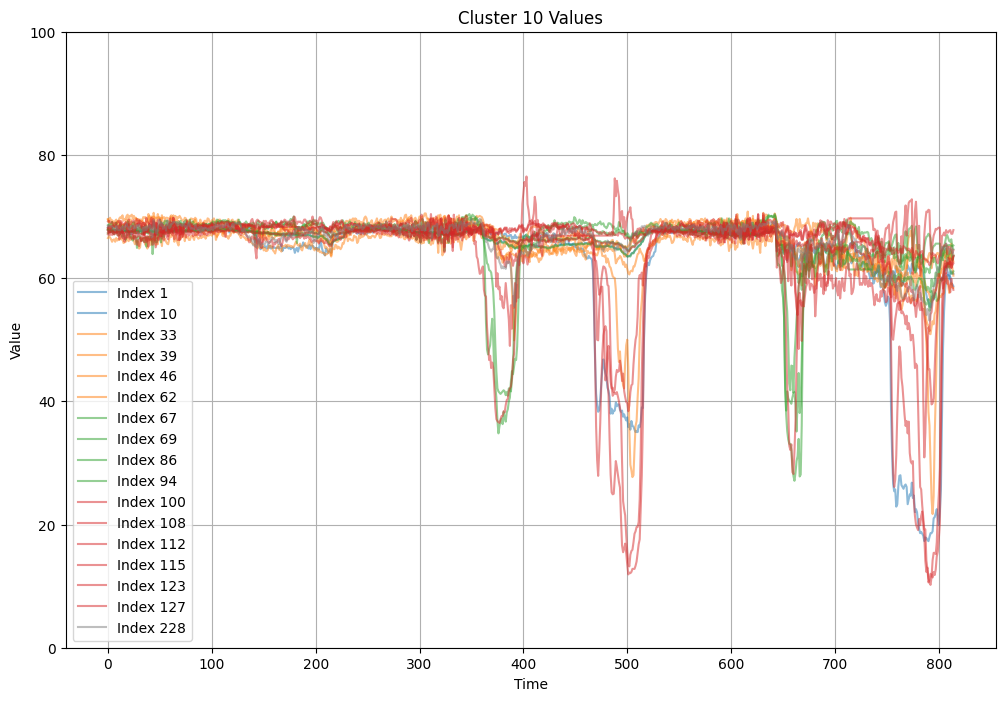

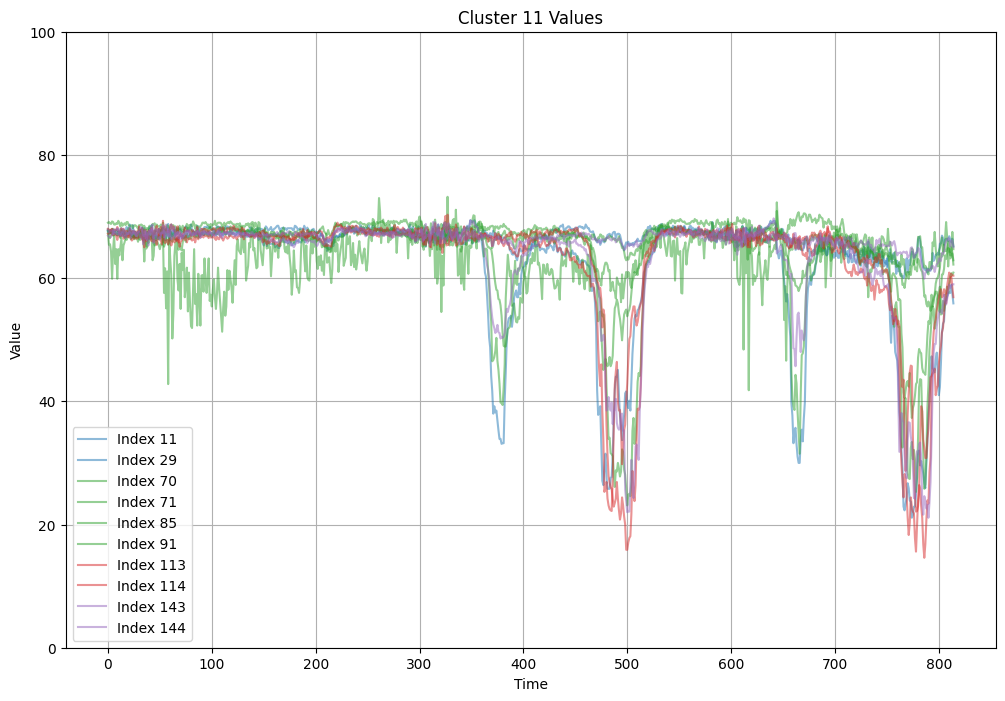

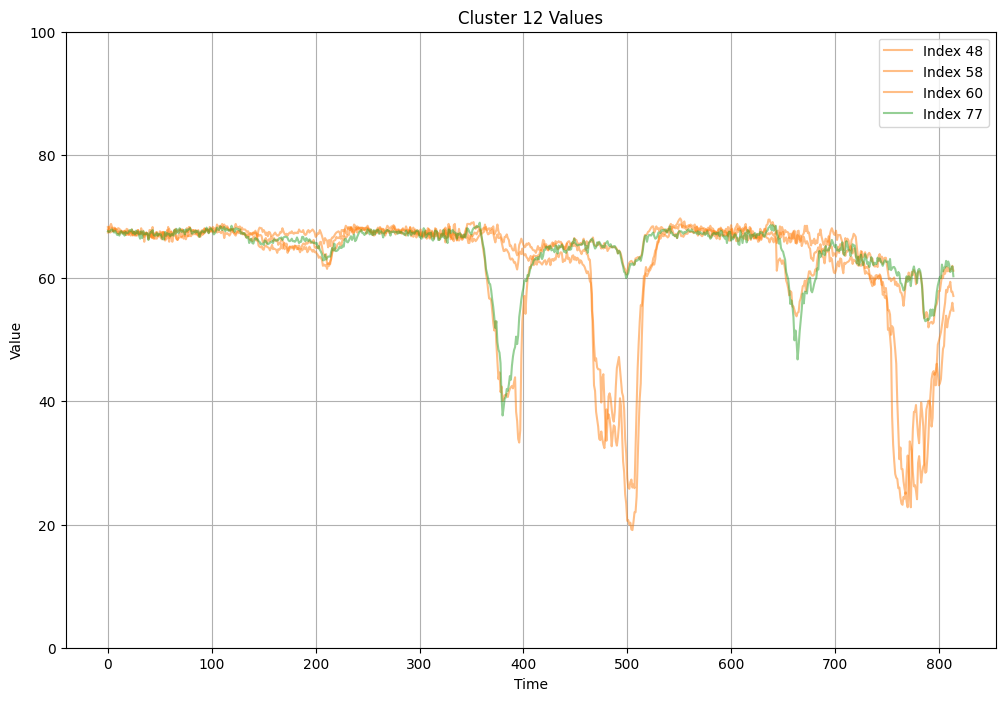

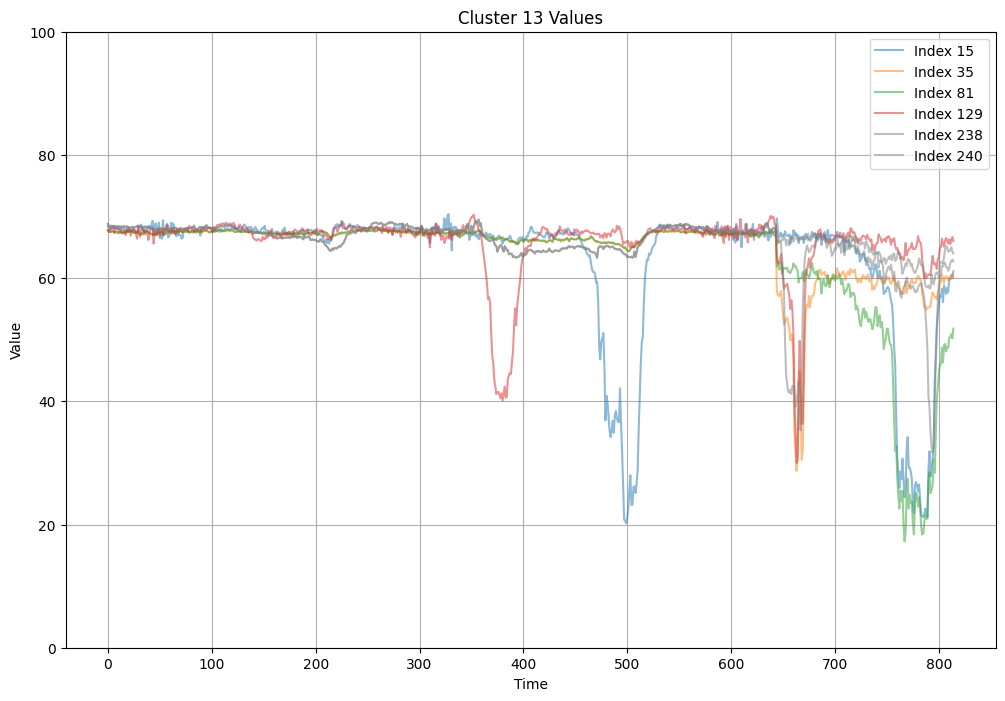

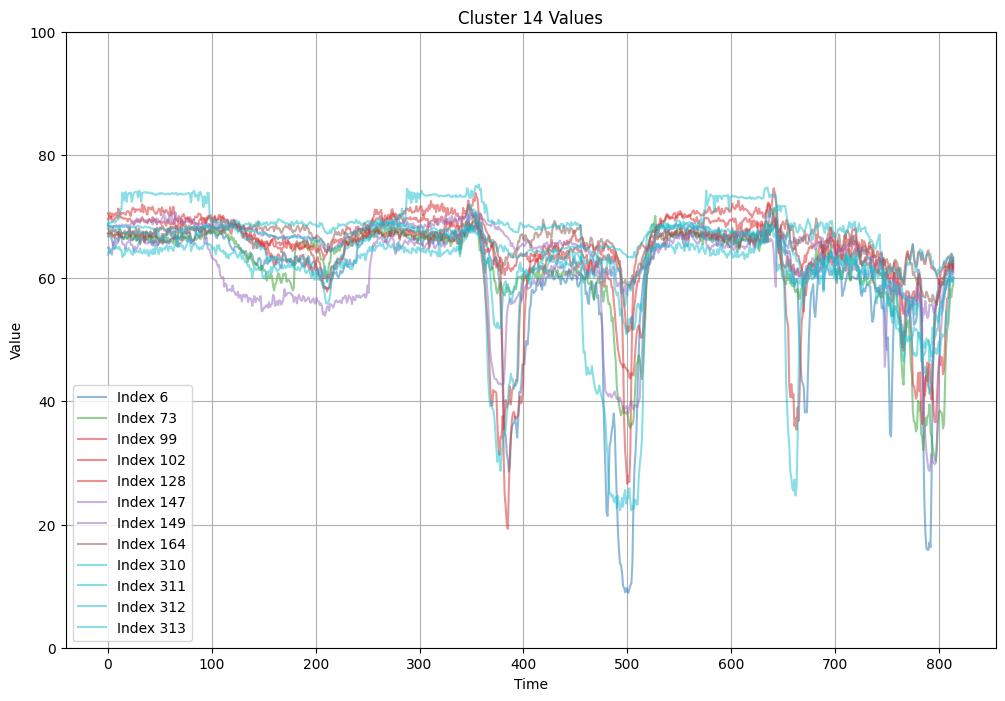

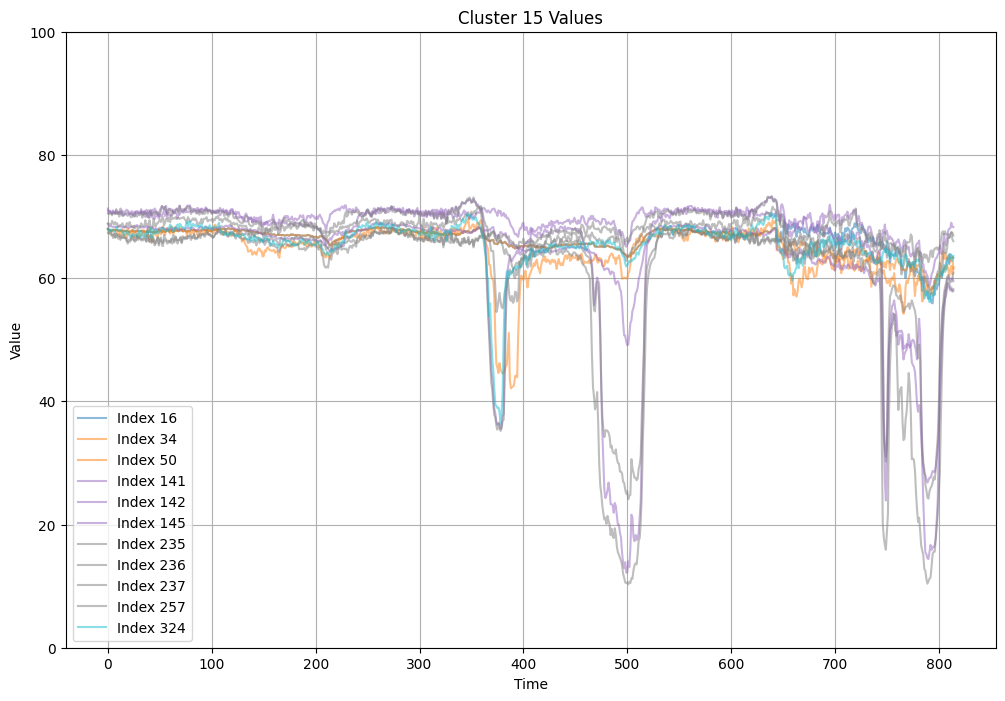

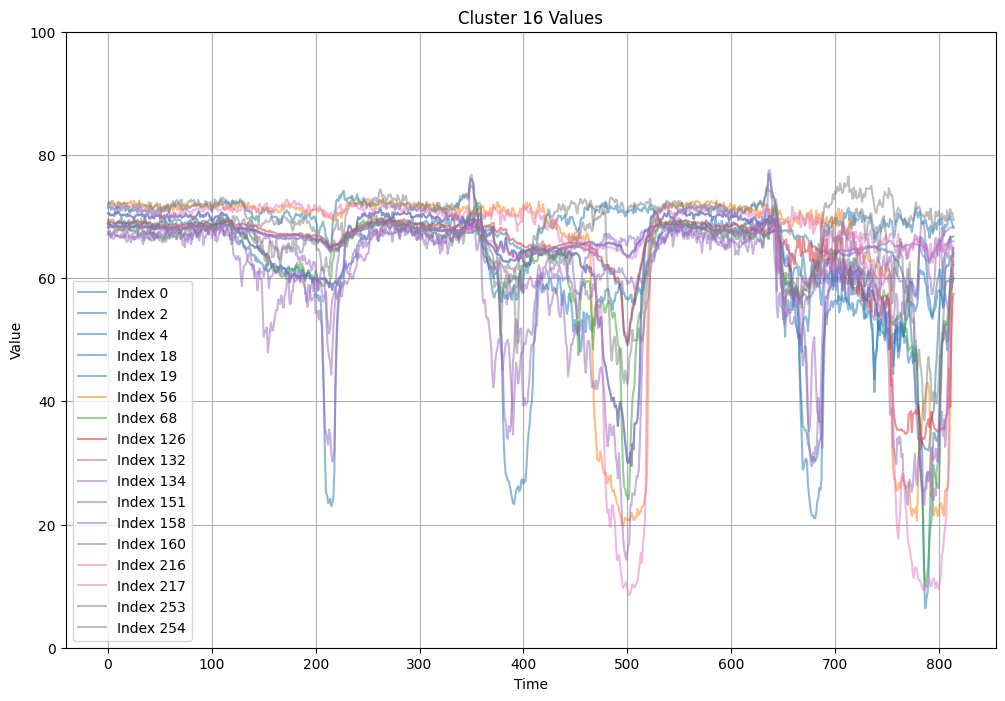

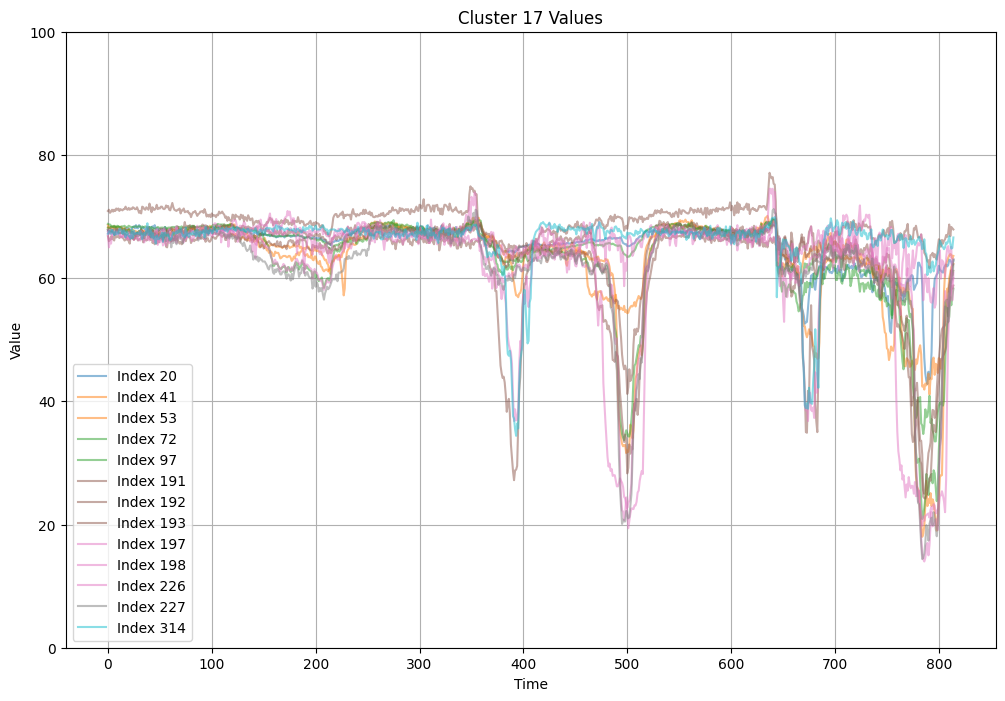

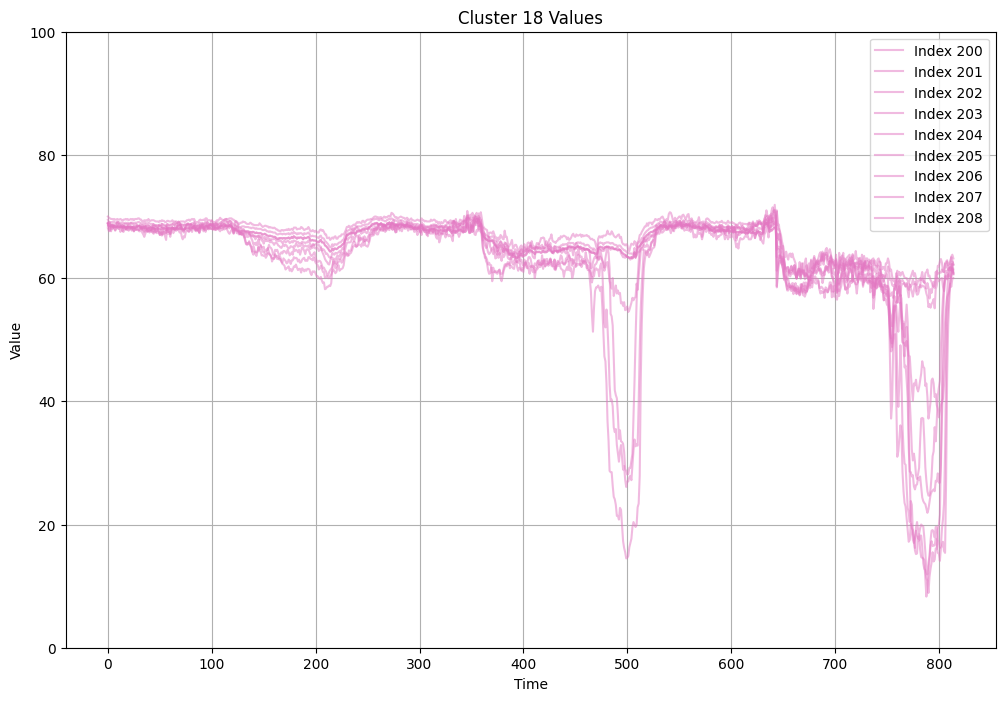

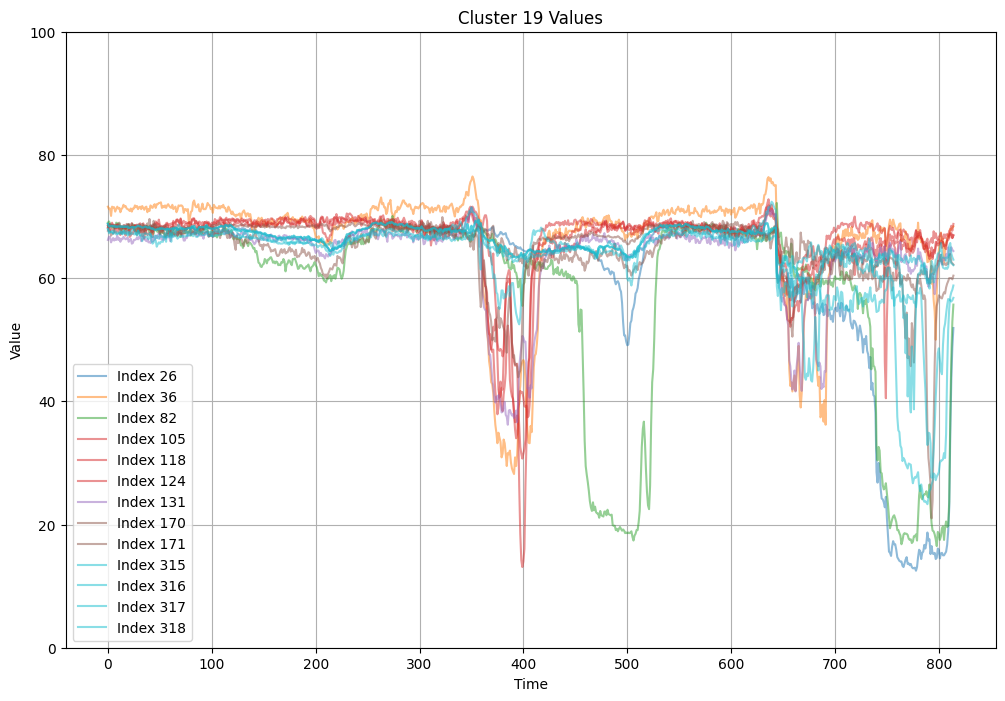

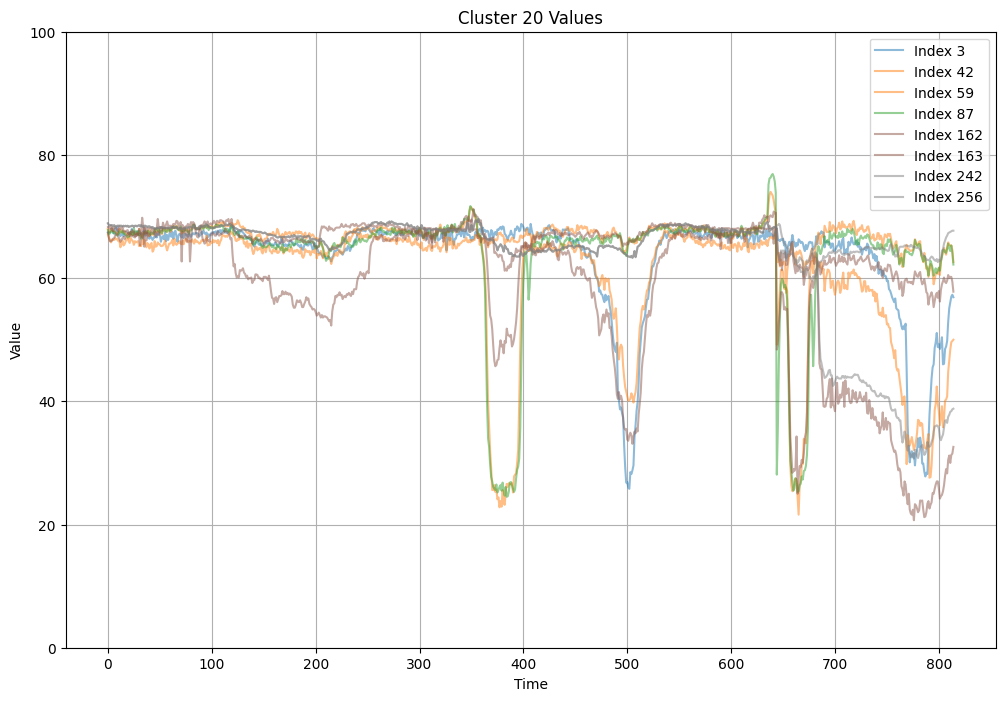

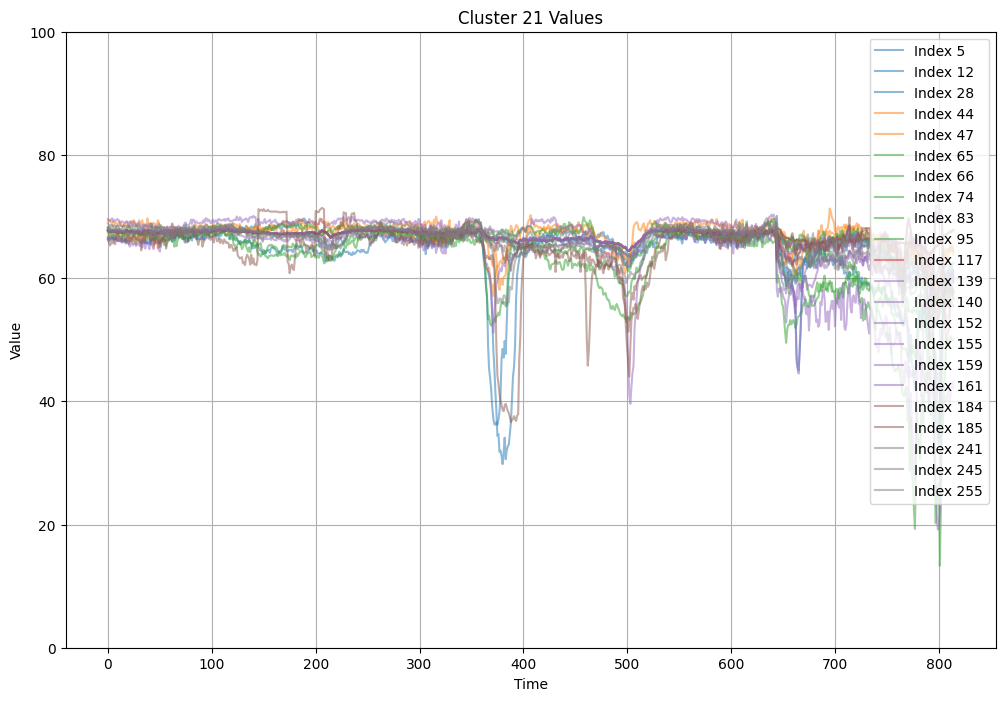

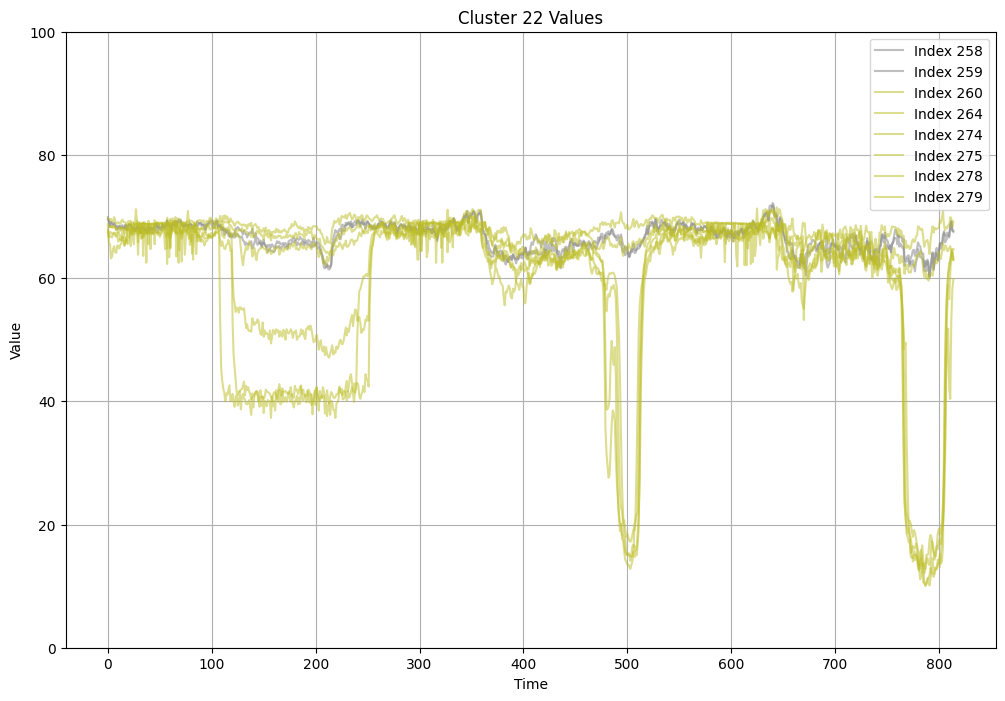

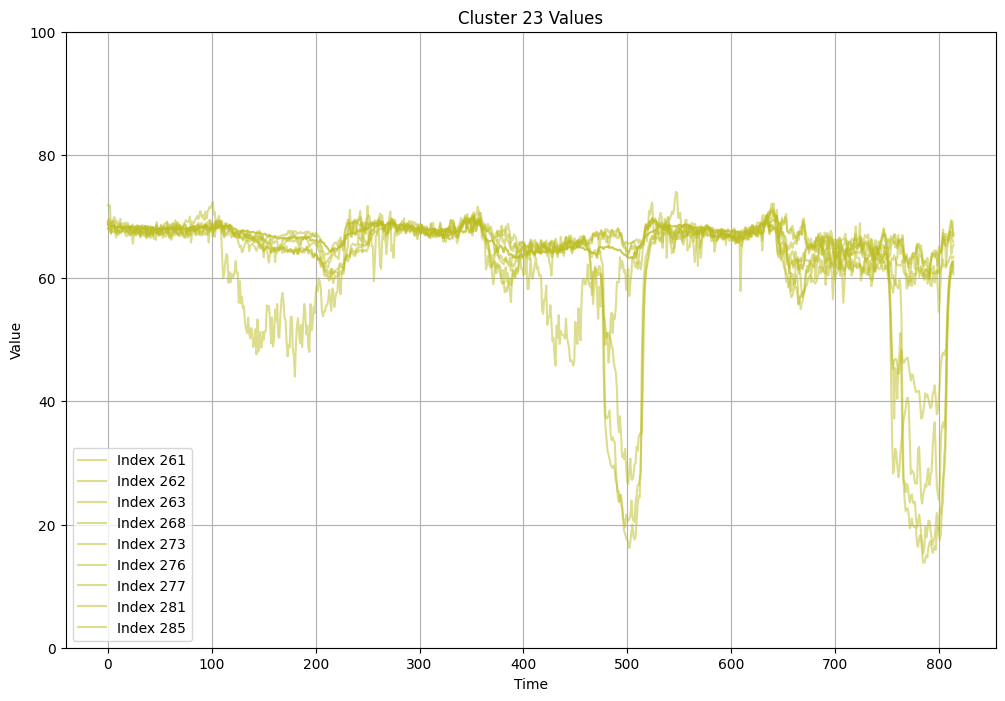

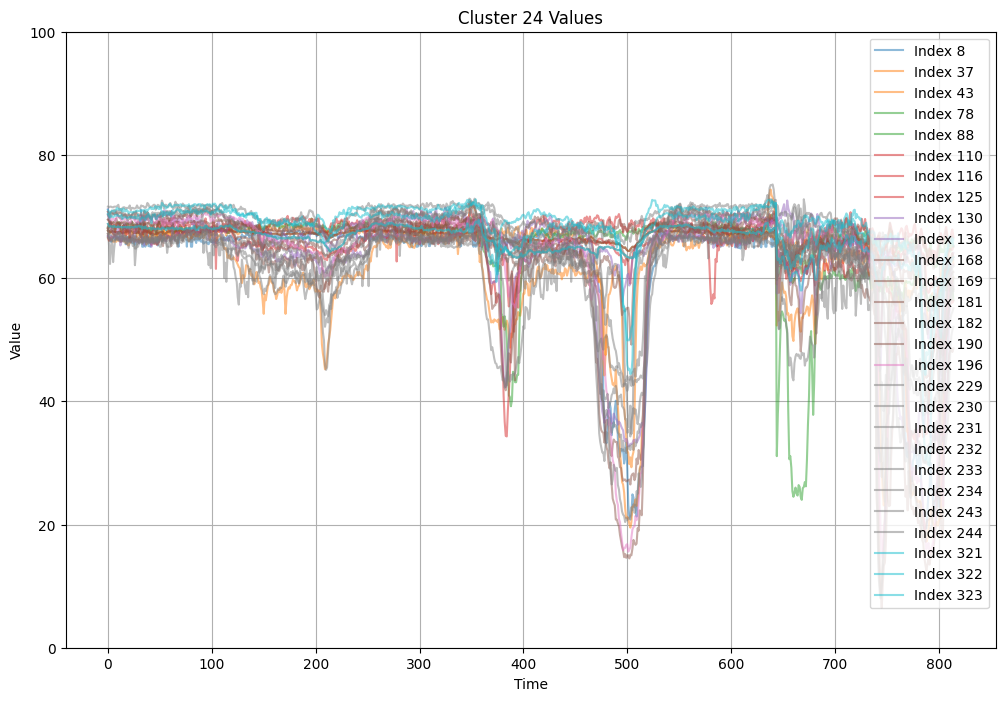

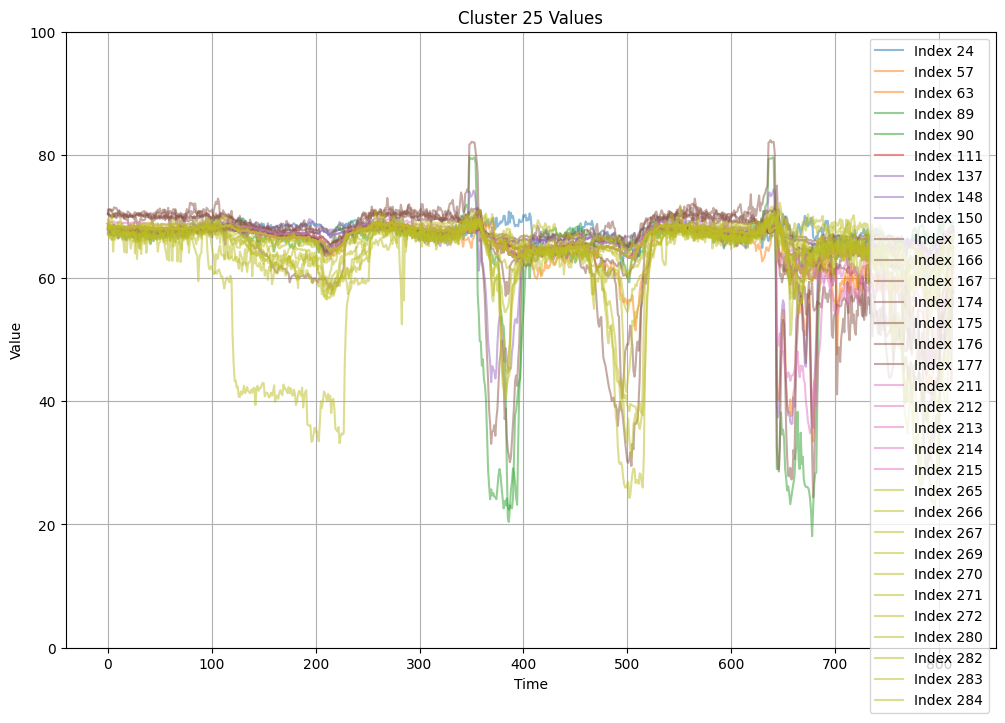

In [19]:
plot_graphs_by_cluster(np.array_split(df, 64)[0], clusters, num_clusters)